In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision
import os
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import copy

## One-Class Neural Network objects

### Network

In [2]:
class OCNN_model(nn.Module):
    def __init__(self, in_features, out_features, nu, var = 0.1, linear_activation = False):
        super(OCNN_model, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.nu = nu
        self.var = var
        self.linear_activation = linear_activation
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.V = nn.Linear(in_features = self.in_features,
                           out_features = self.out_features,
                          bias = True)
        
        self.omega = nn.Linear(in_features = self.out_features,
                           out_features = 1,
                          bias = True)
        
        self.r = nn.parameter.Parameter(torch.rand((1,1)),
                                        requires_grad = False)
        
        if self.linear_activation:
            self.activation = lambda x: x
        
        else:
            self.activation = nn.Sigmoid()
    
    def forward(self, x):
        
        g = self.activation(self.V(x))
        
        yn = self.omega(g)
        
        return yn
    
    def compute_HIs(self, x):
        
        z = self.forward(x)
        
        return z - self.r

### Loss object

In [3]:
class OCNN_Loss(nn.Module):
    
    def __init__(self):
        
        super(OCNN_Loss, self).__init__()
        
    def forward(self, model, z, r_update = False):
        
        if r_update:
            
            r_new = np.percentile(z.detach().cpu().numpy(), model.nu * 100)
            
            return r_new
        else:
            
            #term 1 - L2 regularisation on vector
            term1 = 0
            
            for param in model.omega.parameters():
                term1 += torch.linalg.norm(param)**2
            
            term1 *= 1/2
            
            #term 2 - Frobenius (Euclidean) regularisation on matrix
            term2 = 0
            
            for param in model.omega.parameters():
                term2 += torch.linalg.norm(param)**2
            
            term2 *= 1/2
            
            #term3 - average inlier distance from r max(0, r - distance)
            term3 =(1 / (model.nu)) * torch.mean(F.relu(model.r - z))
            
            #term4 - radius, just a constant
            term4 = -1 * model.r
            
            total_loss = term1 + term2 + term3 + term4
            
            return total_loss

### Optimiser object

In [4]:
class OCNN_optimiser(nn.Module):
    
    def __init__(self, model, learning_rate = 1e-3):
        
        super(OCNN_optimiser, self).__init__()
        
        ls = list(model.V.parameters()) + list(model.omega.parameters())
        self.W_omega_opt = torch.optim.Adam(ls, lr = learning_rate)

    def step(self):
        
        self.W_omega_opt.step()
    
    def zero_grad(self):
        
        self.W_omega_opt.zero_grad()

### Trainer object

In [5]:
class OC_NN_trainer(object):
    
    def __init__(self, OC_NN_model, OC_NN_optimiser, OC_NN_cost, training_iterator, valid_iterator, epochs):
        
        self.model = OC_NN_model
        self.optimiser = OC_NN_optimiser
        self.cost = OC_NN_cost
        self.train_iterator = training_iterator #Fix this later
        self.valid_iterator = valid_iterator #Fix this later
        self.epochs = epochs
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    def optimise(self, z, r_update = False):
        
        loss = self.cost(self.model, z, r_update)
        
        if r_update:
            
            self.model.r[0, 0] = loss
            
            return loss
            
        else:
            loss.backward()
            self.optimiser.step()
            self.optimiser.zero_grad()
        
            return loss.detach().cpu().numpy()
    
    def train_model(self):
        
        cost_train_list = []
        min_loss = np.inf
        pbar = tqdm(total = self.epochs, desc = "Cost at epoch {}: {}".format(0, np.inf))
        
        self.current_epoch_no = 0
        
        for i in range(self.epochs):
            
            cost_train = 0
            radius_train = 0
            cnt_train = 0
            self.model.train()
            
            #Extract data sample (Fix here!)
            #if self.train_iterator.random_seed: #Extracts random samples from the trainer
            #    print("Random iterator is not implemented.")
            #   raise SystemExit

            #elif not self.train_iterator.random_seed: #Sequentially loops through data
                
            for data in self.train_iterator:
                if isinstance(data, tuple): #Check to see if the input is a tuple with labels
                          
                    #Separate data
                    Xdata = data[0].to(self.device)
                    labels = data[1].to(self.device)

                else:
                    #Push to GPU
                    Xdata = data.to(self.device)
                    labels = None
                
                
                #Train step 1 - update omega and V
                z = self.model.forward(Xdata)
                cost_train += self.optimise(z, False)[0, 0]
                
                #Train step 2 - update r
                radius_train += self.optimise(z, True)
                
                cnt_train += 1
            
            #Save
            cost_train_list.append([cost_train / cnt_train, radius_train / cnt_train])
            
            #Store optimal
            if cost_train_list[-1][0] < min_loss:
                min_loss = cost_train_list[-1][0] #Update to be the new minimum
                self.optimal_state_dict = copy.deepcopy(self.model.state_dict()) #Save the optimal state dict
                self.index_min_valid = i
            
            pbar.set_description(desc = "train cost: {}, radius: {}".format(cost_train_list[-1][0], cost_train_list[-1][1]))
            pbar.update(1)
        
        pbar.close()
        
        self.min_loss = min_loss
        self.train_cost = cost_train_list
        
        self.model.eval()
            
    def plotter(self):
        
        v1 = np.array(self.train_cost)
        
        fig, ax = plt.subplots(1, 1, figsize = (12, 10))
        
        ax.set_title("Training curves")
        ax.plot(v1[:, 0], label = "Total loss")
        ax.plot(v1[:, 1], label = "Radius")
        ax.scatter([self.index_min_valid] * v1.shape[1], v1[self.index_min_valid, :], marker = "x", color = "r", label = "minimum validation index")
        ax.legend()

        ax.grid()
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Cost")
            
        fig.tight_layout()
        plt.show()
        

## Create a dataset

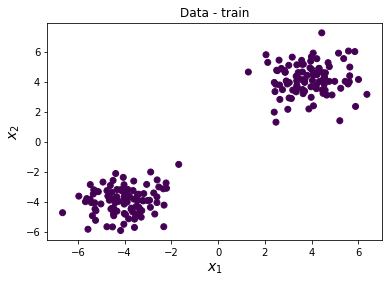

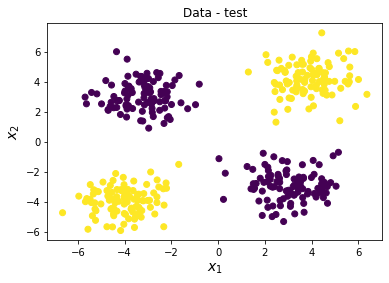

In [6]:
X1 = np.random.randn(100, 2) + np.array([4, 4])
X2 = np.random.randn(100, 2) + np.array([-4, -4])
X3 = np.random.randn(100, 2) + np.array([-3, 3])
X4 = np.random.randn(100, 2) + np.array([3, -3])

l1 = np.ones(100)
l2 = np.ones(100)

X_train = np.vstack((X1, X2))
labels_train = np.hstack((l1, l2))

X_test = np.vstack((X1, X2, X3, X4))
labels_test = np.hstack((l1, l2, -l1, -l2))

plt.figure()
plt.title("Data - train")
plt.scatter(X_train[:, 0], X_train[:, 1], c = labels_train)
plt.xlabel(r"$x_1$", fontsize = 14)
plt.ylabel(r"$x_2$", fontsize = 14)
plt.show()

plt.figure()
plt.title("Data - test")
plt.scatter(X_test[:, 0], X_test[:, 1], c = labels_test)
plt.xlabel(r"$x_1$", fontsize = 14)
plt.ylabel(r"$x_2$", fontsize = 14)
plt.show()

train_dataloader = DataLoader(X_train.astype('float32'), batch_size=64, shuffle=True)
test_dataloader = DataLoader(X_test.astype('float32'), batch_size=64, shuffle=False)

## Initialise a model

In [7]:
#Define model
in_features = X_train.shape[1]
model = OCNN_model(in_features, out_features = 100, nu = 0.01, linear_activation = False)

#Push to GPU
model.to(model.device)

#Deine optimiser
ocnn_opt = OCNN_optimiser(model, learning_rate = 1e-3)

#Define cost
ocnn_cost = OCNN_Loss()

#Define trainer
my_trainer = OC_NN_trainer(model, ocnn_opt, ocnn_cost, train_dataloader, None, 3000)

## Train a model

train cost: 190.99575424194336, radius: 196.47444835662841: 100%|██████████████████| 3000/3000 [01:06<00:00, 45.27it/s]


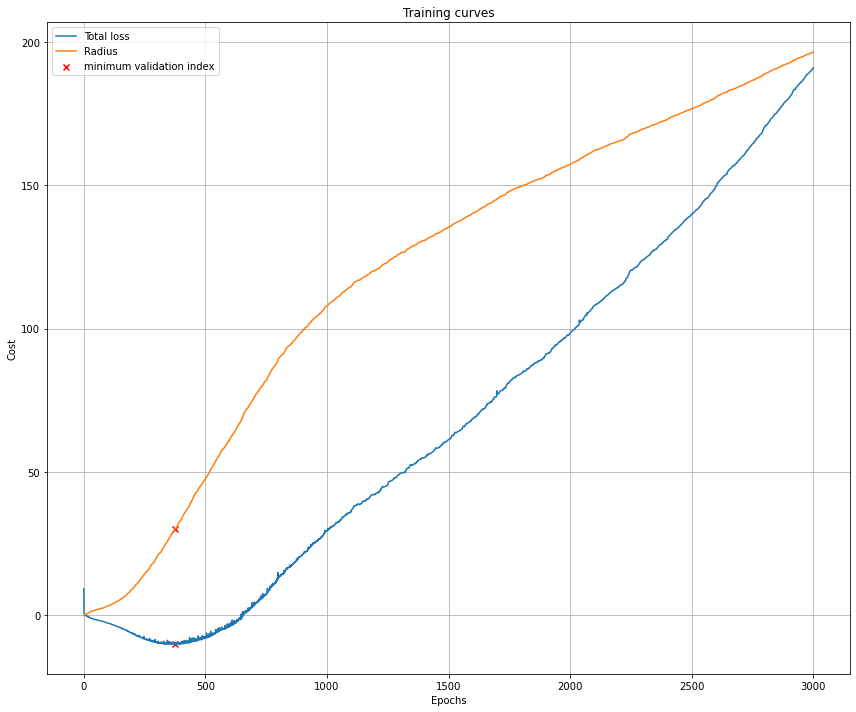

Selecting the optimal state dictionary!


In [8]:
my_trainer.train_model()

my_trainer.plotter()

if hasattr(my_trainer, "optimal_state_dict"):
    print("Selecting the optimal state dictionary!")
    model.load_state_dict(my_trainer.optimal_state_dict)

In [16]:
print(my_trainer.optimal_state_dict["r"], my_trainer.min_loss)

tensor([[30.3223]], device='cuda:0') -10.045051097869873


## Test the model

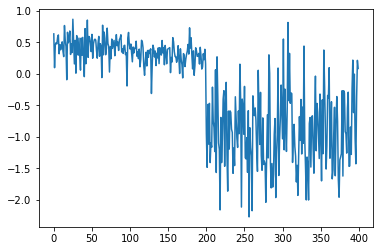

In [17]:
z_pred = np.zeros((len(labels_test), 1))
start = 0

for data in test_dataloader:
    if isinstance(data, tuple): #Check to see if the input is a tuple with labels

        #Separate data
        Xdata = data[0].to(model.device)
        labels = data[1].to(model.device)

    else:
        #Push to GPU
        Xdata = data.to(model.device)
        labels = None  
    
    with torch.no_grad():
        HI = model.compute_HIs(Xdata)
        
        z_pred[start: start + Xdata.size(0)] = HI.cpu().numpy()
        
        start += Xdata.size(0)

plt.figure()
plt.plot(z_pred[:, 0])
plt.show()

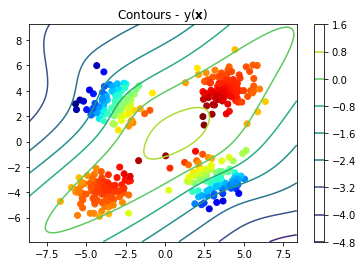

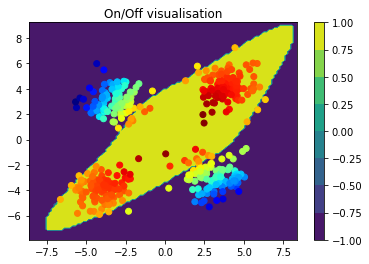

In [18]:
N_grid = 100
X_m, Y_m = np.meshgrid(np.linspace(np.min(X_test[:, 0]) - 2, np.max(X_test[:, 0]) + 2, N_grid), 
                       np.linspace(np.min(X_test[:, 1]) - 2, np.max(X_test[:, 1]) + 2, N_grid))

X_grid = np.hstack((X_m.reshape(-1, 1), Y_m.reshape(-1, 1)))

X_grid = torch.from_numpy(X_grid.astype('float32')).to(model.device)

with torch.no_grad():
    Z = model.compute_HIs(X_grid).cpu().numpy()

plt.figure()
plt.contour(X_m, Y_m, Z.reshape(N_grid, N_grid))
plt.colorbar()
plt.scatter(X_test[:, 0], X_test[:, 1], c = z_pred, cmap = plt.cm.jet)
#plt.xlabel()
#plt.ylabel()
plt.title(r"Contours - y($\mathbf{x}$)")

plt.show()

plt.figure()
plt.contourf(X_m, Y_m, np.sign(Z.reshape(N_grid, N_grid)))
plt.colorbar()
plt.scatter(X_test[:, 0], X_test[:, 1], c = z_pred, cmap = plt.cm.jet)
#plt.xlabel()
#plt.ylabel()
plt.title("On/Off visualisation")
plt.show()

## Testing the model on harder problems:

### Download MNIST

In [19]:
data_dir = 'MNIST_data'

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)
    
train_set = torchvision.datasets.MNIST(root=data_dir, 
                                       train=True,
                                       download=True)

test_set = torchvision.datasets.MNIST(root=data_dir, 
                                      train=False, 
                                      download=True)

In [13]:
train_data = train_set.data.numpy()/255

np.mean(train_data), np.std(train_data)

(0.1306604762738429, 0.3081078038564622)

## Select known class and transform using PCA

In [28]:
#Define transform 1
transform_data = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1306604762738429),(0.3081078038564622)),
        torchvision.transforms.Lambda(lambda x: x.reshape(-1, 784))
        ])


known_class = [0]
train_data = train_set.data.numpy()
train_labels = train_set.targets.numpy()

train_list = []
for i in known_class:
    train_list.append(transform_data(train_data[train_labels == i, :, :]))
    
train_data = np.concatenate(train_list, axis = 0)

#Fit PCA model
print("Fitting the PCA model")
pca = PCA(n_components = 0.8).fit(train_data)
print("Fitted")

transform_pca = torchvision.transforms.Compose([
        torchvision.transforms.Lambda(lambda x: pca.transform(x))
        ])

Fitting the PCA model
Fitted


### Select unknown classes

In [29]:
unknown_class = [2, 4, 9]

test_data = test_set.data.numpy()
test_labels = test_set.targets.numpy()

test_list = []
for i in known_class + unknown_class:
    print()
    test_list.append(transform_data(test_data[test_labels == i, :, :]))

train_dataloader = DataLoader(transform_pca(np.concatenate(train_list, axis = 0)), 
                                            batch_size=64, 
                                            shuffle=True)
                              
test_dataloader = DataLoader(transform_pca(np.concatenate(test_list, axis = 0)), 
                                           batch_size=64, 
                                           shuffle=False)

torch.Size([64, 101]) tensor(-20.0839) tensor(24.3313)
torch.Size([64, 101]) tensor(-18.9389) tensor(0.3553)


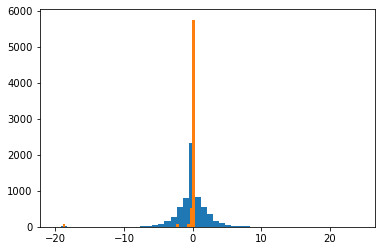

In [40]:
%matplotlib inline

a = next(iter(train_dataloader))
b = next(iter(test_dataloader))
print(a.shape, a.min(), a.max())
print(b.shape, b.min(), b.max())

plt.figure()
plt.hist(a.reshape(-1).cpu().numpy(), bins = 50)
plt.hist(b.reshape(-1).cpu().numpy(), bins = 50)
plt.show()

### Initialise model

In [41]:
#Define model
in_features = pca.n_components_

model = OCNN_model(in_features, out_features = 20, nu = 0.05, linear_activation = False)

#Push to GPU
model.to(model.device)

#Deine optimiser
ocnn_opt = OCNN_optimiser(model, learning_rate = 1e-3)

#Define cost
ocnn_cost = OCNN_Loss()

#Define trainer
my_trainer = OC_NN_trainer(model, ocnn_opt, ocnn_cost, train_dataloader, None, 200)

### Train the model

train cost: 10.977973979006531, radius: 28.95011398971723: 100%|█████████████████████| 200/200 [01:44<00:00,  1.92it/s]


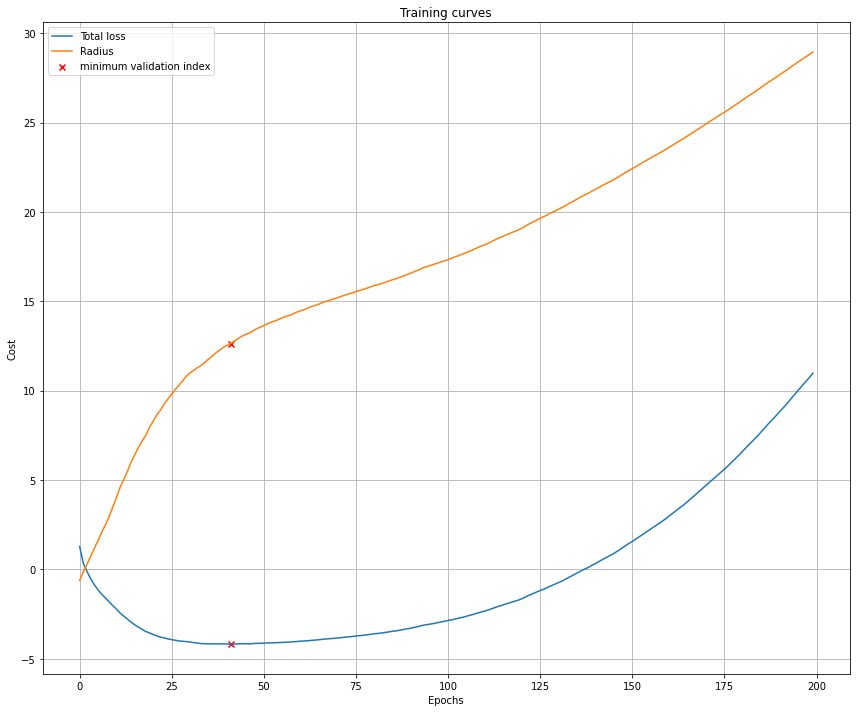

Selecting the optimal state dictionary!


In [42]:
my_trainer.train_model()

my_trainer.plotter()

if hasattr(my_trainer, "optimal_state_dict"):
    print("Selecting the optimal state dictionary!")
    model.load_state_dict(my_trainer.optimal_state_dict)

### Test the model

<IPython.core.display.Javascript object>


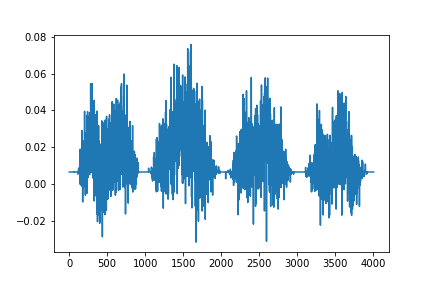

In [43]:
%matplotlib notebook

z_pred = []
start = 0

for data in test_dataloader:
    if isinstance(data, tuple): #Check to see if the input is a tuple with labels

        #Separate data
        Xdata = data[0].to(model.device)
        labels = data[1].to(model.device)

    else:
        #Push to GPU
        Xdata = data.to(model.device)
        labels = None  
    
    with torch.no_grad():
        HI = model.compute_HIs(Xdata)
        
        z_pred.append(HI.cpu().numpy())
        

z_pred = np.concatenate(z_pred, axis = 0)# + model.r.cpu().numpy()

plt.figure()
plt.plot(z_pred[:, 0])
plt.show()

In [36]:
my_trainer.optimal_state_dict["r"]

tensor([[29.9492]], device='cuda:0')